### Problem 2: Gaussian Process Regression Solution

In [105]:
### Part a

In [119]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Loading the data
df=pd.read_excel('Concrete_Data.xls')
y=df.iloc[:,-1].values.reshape(-1,1)
X=df.iloc[:,:-1].values.reshape(-1,df.iloc[:,:-1].shape[1])

# Splitting the data into a test and train set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

# Verify Scaling:
print(f'Mean of X_train: {np.mean(X_train)}')
print(f'Mean of X_test: {np.mean(X_test)}')
print(f'Variance of X_train: {np.var(X_train)}' )
print(f'Variance of X_test: {np.var(X_test)}' )

Mean of X_train: 1.5028816533067306e-15
Mean of X_test: 8.3140973429858e-16
Variance of X_train: 0.9999999999999982
Variance of X_test: 0.9999999999999992


In [51]:
### Part b

In [65]:
def rbf_kernel(X1, X2, sigma, Ls):
    N = X1.shape[0]
    M = X2.shape[0]
    D = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    K = sigma * np.exp(-D / (2 * Ls ** 2))
    return K

sigma = 1.0
Ls = 2.0

K = rbf_kernel(X_train, X_train, sigma, L)
print(K.shape)

(721, 721)


In [75]:
### Part c

In [76]:
from scipy.linalg import cholesky

def gp_regression_pred(X_train, y_train, X_test, gamma, sigma, Ls):
    n = X_train.shape[0]
    
    ym = np.mean(y_train)
    y = y_train - ym
    K11 = rbf_kernel(X_train, X_train, sigma, Ls)
    K12 = rbf_kernel(X_train, X_test, sigma, Ls)
    K22 = rbf_kernel(X_test, X_test, sigma, Ls)
    L = cholesky(K11 + (gamma) * np.eye(n), lower=True)
    
    # Calculate mean
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    gp_mean = ym + K12.T @ alpha
    
    # Calculate variance
    v = np.linalg.solve(L, K12)
    gp_variance = K22 - v.T @ v
    
    return gp_mean, gp_variance
gamma=1e-5
mean, var = gp_regression_pred(X_train, y_train, X_test, gamma, sigma, Ls)
print(np.mean(mean))
print(np.var(mean))

39.10782472834229
492.5046960399701


In [77]:
### Part d

In [78]:
def LogMarLhood(X_train, y_train, gamma, sigma, Ls):
    n = X_train.shape[0]
    ym = np.mean(y_train)
    y = y_train - ym
    
    K11 = rbf_kernel(X_train, X_train, sigma, Ls)
    L = cholesky(K11 + gamma * np.eye(n), lower=True)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    
    LMHood = -1/2 * y.T @ alpha - np.sum(np.log(np.diag(L))) - n/2 * np.log(2 * np.pi)
    
    return LMHood
LMHood = LogMarLhood(X_train, y_train, gamma, sigma, Ls)
print(LMHood)


[[-1.14557442e+08]]


In [79]:
### Part e

In [97]:
def Grid_Search(X_train, y_train, Lss, sigmas, gammas):
    n_search = len(Lss)
    params = np.array(np.meshgrid(Lss, sigmas, gammas)).T.reshape(-1, 3)

    best = float('-inf')
    best_gamma, best_sigma, best_h = None, None, None
    for param_set in params:
        cur_h, cur_sigma, cur_gamma = param_set
        logml = log_marginal_likelihood(X_train, y_train, cur_gamma, cur_sigma, cur_h)
        if logml > best:
            best = logml
            best_gamma, best_sigma, best_L = cur_gamma, cur_sigma, cur_h

    return best_gamma, best_sigma, best_L

In [98]:
### Part f

In [99]:
Lss = np.logspace(-1, 1, 10)*np.linalg.norm(np.std(X_train))
gammas = np.logspace(-1, 1, 10) 
sigmas = np.logspace(-1, 1, 10)*np.std(y_train)
best_gamma, best_sigma, best_L = Grid_Search (X_train, y_train, Lss, sigmas, gammas)
print(best_gamma, best_sigma, best_L)

10.0 167.91744896796627 1.291549665014883


In [100]:
### Part g

In [103]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_train_pred, y_train_std = gp_regression_pred(X_train, y_train, X_train, best_gamma, best_sigma, best_L)
y_test_pred, y_test_std = gp_regression_pred(X_train, y_train, X_test, best_gamma, best_sigma, best_L)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R2 Score Train = {r2_train: 0.3f}')
print(f'R2 Score Test = {r2_test: 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=y_train_pred): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=y_test_pred): 0.3f}')

R2 Score Train =  0.964
R2 Score Test =  0.830
MAE Train =  2.252
MAE Test =  4.746


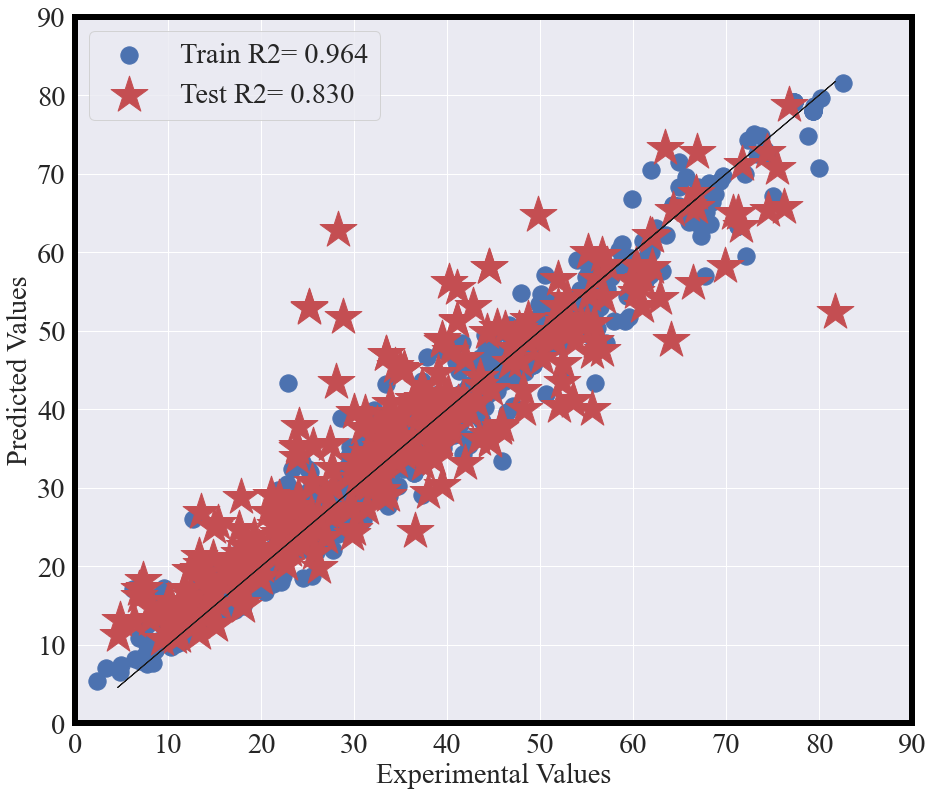

In [121]:
desired_fig_size = (15, 13)

# Calculate scaling factors for width and height
width_scale = desired_fig_size[0] / 7
height_scale = desired_fig_size[1] / 5

# Calculate the average scaling factor to adjust font size
average_scale = (width_scale + height_scale) / 2

# Apply the scaling factor to adjust font size
font_size = 12 * average_scale

# Create the figure
fig2 = plt.figure(figsize=desired_fig_size)
ax = plt.subplot(1, 1, 1)

# Plotting the figure
plt.scatter(y_train, y_train_pred, c='b', s=300, label=f'Train R2={(r2_train): 0.3f}')
plt.plot(y_test, y_test, linewidth=1, c='k', label='')
plt.scatter(y_test, y_test_pred, c='r', marker='*', s=1500, label=f'Test R2={(r2_test): 0.3f}')


ax.set_xlim([0, 90])
ax.set_ylim([0, 90])

plt.xlabel('Experimental Values', size=font_size)
plt.ylabel('Predicted Values', size=font_size)
plt.legend(loc='upper left', ncol=1, fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(6)
    spine.set_color('black')

plt.rc('font', family='Times New Roman', size=font_size)

plt.show()